In [8]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import getpass
import os; os.sys.path.append(os.path.dirname(os.path.abspath('.'))) #Use this to import functions from /parsing log/ folder
from utils import find_student_log_file
np.set_printoptions(precision=2)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('precision', 2)

%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 25, 15

## Let's get a sense of the data

In [10]:
FOLDER =  'C:\\Users\\'+getpass.getuser()+'\\Documents\\Personal Content\\Lab_skills_study\\parsed log data'
studentid = '90447168'
sim = 'beers'
parsed_file = find_student_log_file(FOLDER,sim,studentid)
df = pd.read_table(parsed_file, sep='\t')
# df = pd.read_csv('dream_table_beers_90447168_2017-01-17_11.22.45.csv')

In [6]:
df.head(n=2)

,User,Sim,Time,Index,User or Model?,Event,Item,Action,Laser on status,Wavelength,Width,Concentration,Absorption,Detector location,Ruler location,Table,X axis,Y axis,X axis scale,Y axis scale,Experiment #s included,Notes
0,90447168,light_absorbance,0.0,0,model,initializing,sim,beersLawLab.sim.simStarted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,90447168,light_absorbance,0.0,2,model,updating state,NaN,NaN,False,780.0,1.0,0.1,NaN,"{u'y': 2, u'x': 6.3}","{u'y': 3.58, u'x': 3.3}",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# THere are user and model actions, but how many of each?
df.groupby('User or Model?')['Event'].count()

User or Model?
model    2036
user     3844
Name: Event, dtype: int64

In [8]:
#Which events are user or model actions?
print "User actions: ", ", ".join(df[df['User or Model?']=='user']['Event'].unique())
print "Model actions: ", ", ".join(df[df['User or Model?']=='model']['Event'].unique())

User actions:  toggle laser, dragStarted, dragged, dragEnded, editing notes, recording data, expanding table, expanding graph, Adding data to graph, Selecting Y-axis, Selecting X-axis, Changed concentration, Removing data from table, Selecting scale of Y-axis
Model actions:  initializing, updating state


In [9]:
#list all possible items for the events to inform action to family dictionary
print df['Item'].unique()

['sim' nan 'laser button' 'cuvetteNode' 'notepad' 'wavelengthControls'
 'solutionControls' 'detectorNode' 'table' 'graph' 'trialNumber 1'
 'Y-axis dropdown menu' 'X-axis dropdown menu' 'trialNumber 2'
 'trialNumber 3' 'concentration slider' 'trialNumber 4' 'trialNumber 5'
 'trialNumber 6' 'trialNumber 7' 'trialNumber 8' 'trialNumber 9'
 'trialNumber 20' 'trialNumber 19' 'trialNumber 18' 'trialNumber 17'
 'trialNumber 16' 'trialNumber 15' 'trialNumber 14' 'trialNumber 13'
 'trialNumber 12' 'trialNumber 11' 'trialNumber 10'
 'Y-axis scale dropdown menu']


## Let's massage the data
### First, we don't care to visualize model actions so we ignore them

In [10]:
df = df[df['User or Model?'] != 'model']
df.groupby('User or Model?')['Event'].count()

User or Model?
user    3844
Name: Event, dtype: int64

### Next we add pauses

In [11]:
#Let's try and add pauses to the mix.
PAUSE_LENGTH = 15

def detect_pause(row,current_time,next_time):
    duration_of_action = next_time - current_time
    if duration_of_action >= PAUSE_LENGTH:
        row['Family']='Pause'
        return row

df['Timeshifted'] = df[['Time']].shift(-1)
df_pauses = df.loc[df['Timeshifted']-df['Time']>=PAUSE_LENGTH]
df_pauses.loc[:,('User or Model?')]='user'
df_pauses.loc[:,('Event')]='Pause'
df_pauses.loc[:,('Item')]='Pause'
df_pauses.loc[:,('Action')]='Pause'
df_pauses.loc[:,('Time')]=df_pauses[('Time')]+5 #shift it by 5 sec since otherwise the original event and pause have the same start time
df = pd.concat([df,df_pauses],ignore_index=True)
df = df.sort_values('Time')

C:\Users\sperez8\AppData\Local\Continuum\Anaconda2\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [12]:
# Define actions families
# I'm not sure what is 'Changed concentration' - is it using the arrows to change concentration? Yes!
action_to_family = {'N':['editing notes'],
                    'M':['recording data'],
                   'Dt':['Removing data from table'],
                    'G':['Adding data to graph','Selecting Y-axis','Selecting X-axis', 'Selecting scale of Y-axis','Selecting scale of X-axis'],
                   'I':['expanding table','collapsing table','expanding graph','collapsing graph'],
                    'P':['Pause']}
variable_actions = ['toggle laser','dragEnded','dragged','dragStarted','Changed concentration']
family_full_names = {'I':'Interface',
                    'P':'Pause',
                    'G':'Graph (add/del/edit)',
                    'Dt':'Data Table (del/move)',
                    'N':'Notes',
                    'M':'Record',
                    'Vd':'Detector',
                    'Vw':'Wavelength',
                    'Vc':'Width',
                    'Vs':'Concentration',
                    'Vl':'Laser toggle',
                    }

In [13]:
# Populate family column based on action_to_family dict above
#First we reverse the dictionary to map events to families.
event_to_family = {}
for family, events in action_to_family.iteritems():
    for event in events:
        event_to_family[event]=family

def map_event_family(event,item):
    if event in variable_actions:
        return 'V'+item[0]
    else:
        return event_to_family[event]

df['Family'] = df.apply(lambda row: map_event_family(row['Event'],row['Item']), axis=1)

### Next we get block sequences and visualize

In [14]:
def get_blocks_withTime(df, students, ignore=[], add_spaces=False):
    
    '''
    This function gets action sequences in block form along with time stamps for each block for plotting.
    '''
    blocks = {student:'' for student in students}
    time_coords = {student:[] for student in students}
    for student in students:
        sequence =  list(df['Family'])
#         print sequence
        time_stamps =  list(df['Time'])
        time_coord=[]  #coordinate array for broken bar plot, takes array of (start time, duration)
        p = re.compile(r'([A-Z][a-z]{0,3})\1*')  #this regex finds all action blocks of length 1+
#         print ''.join([action for action in sequence if action not in ignore])
        #print time_stamps
        ##use finditer to return a sequence of matches as an iterator
        previous_start = 0
        for match in p.finditer(''.join([action for action in sequence if action not in ignore])):
            ind = match.span()  #this gives start and end of matched block
            ##for matches of action denoted by more than 1 letter (e.g. Tb), need to correct the span
#             print match.group(), match.span(), ind[1]-ind[0], len(set(match.group())),
            ##set() function yields unique elements of a set, which allows picking out those actions with > 1 letter
            ##for e.g. if match.group() gives "CCCCC", then set() of that is "C" while for "TbTbTb" we'd have "T","b"
            ind = (previous_start, previous_start + (ind[1]-ind[0])/len(set(match.group())))
            #print ind
            previous_start = ind[1]
            if ind[1] >= len(time_stamps):  #block location offset from real index by 1
                duration = time_stamps[ind[1]-1] - time_stamps[ind[0]]  #time duration of block
                #print time_stamps[ind[1]-1], time_stamps[ind[0]]  #time duration of block
            else:
                duration = time_stamps[ind[1]] - time_stamps[ind[0]]
                #print time_stamps[ind[1]] , time_stamps[ind[0]]
            time_coord.append((time_stamps[ind[0]],duration))
            #print match.group(), match.span(), duration
        #actual regex that converts block of similar actions to just one action
        block = re.sub(r'([A-Z][a-z]{0,3})\1+', r'\1',''.join([action for action in sequence if action not in ignore]))
        if add_spaces:
            spaced_block = block[0]
            for b in block[1:]:
                spaced_block += ' '+b
            blocks[student] += spaced_block
            time_coords[student] = time_coord
        else:
            blocks[student] += block
            time_coords[student] = time_coord
    return blocks, time_coords

In [15]:
def plot_barGraph_new(df, studentID, family_plot_order, ignore=[]):
    '''
    This function plots timeline action plots
    '''
    #get blocks of actions and their time coordinate for broken bar plot
    blocks, time_coords = get_blocks_withTime(df, {studentID}, ignore)
    #create figure and axes
    fig, ax = plt.subplots()
    
    #split sequences so that each block is an element of a list
    splitblocks = re.compile(r'([A-Z]{1}[a-z]{0,3})\1*').split(blocks[studentID])
    splitblocks = [s for s in splitblocks if s != ""]

    #grab time coordinates of each blocks from dict 
    time_coord = time_coords[studentID]
    axis_labels = []

    colors = sns.color_palette("hls", len(family_plot_order))
    
    for i,action in enumerate(family_plot_order):
        axis_labels.append(family_full_names[action])
        out = [(x,y) for x,y in zip(splitblocks,time_coord) if action == x]
        _, time_coord_filtered = map(list,zip(*out))  
        ax.broken_barh(time_coord_filtered,(10*i,9),facecolors=colors[i],linewidth=0.5,edgecolor='k')

    ax.set_ylim(0, len(axis_labels)*10)
    ax.set_xlim(0, time_coord[-1][0]+time_coord[-1][1]+2)
    ax.set_xlabel('Time (s)', fontsize=25)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.set_yticks(range(5,len(axis_labels)*10+15,10))
    ax.set_yticklabels(axis_labels, fontsize=25)
    ax.grid(True)

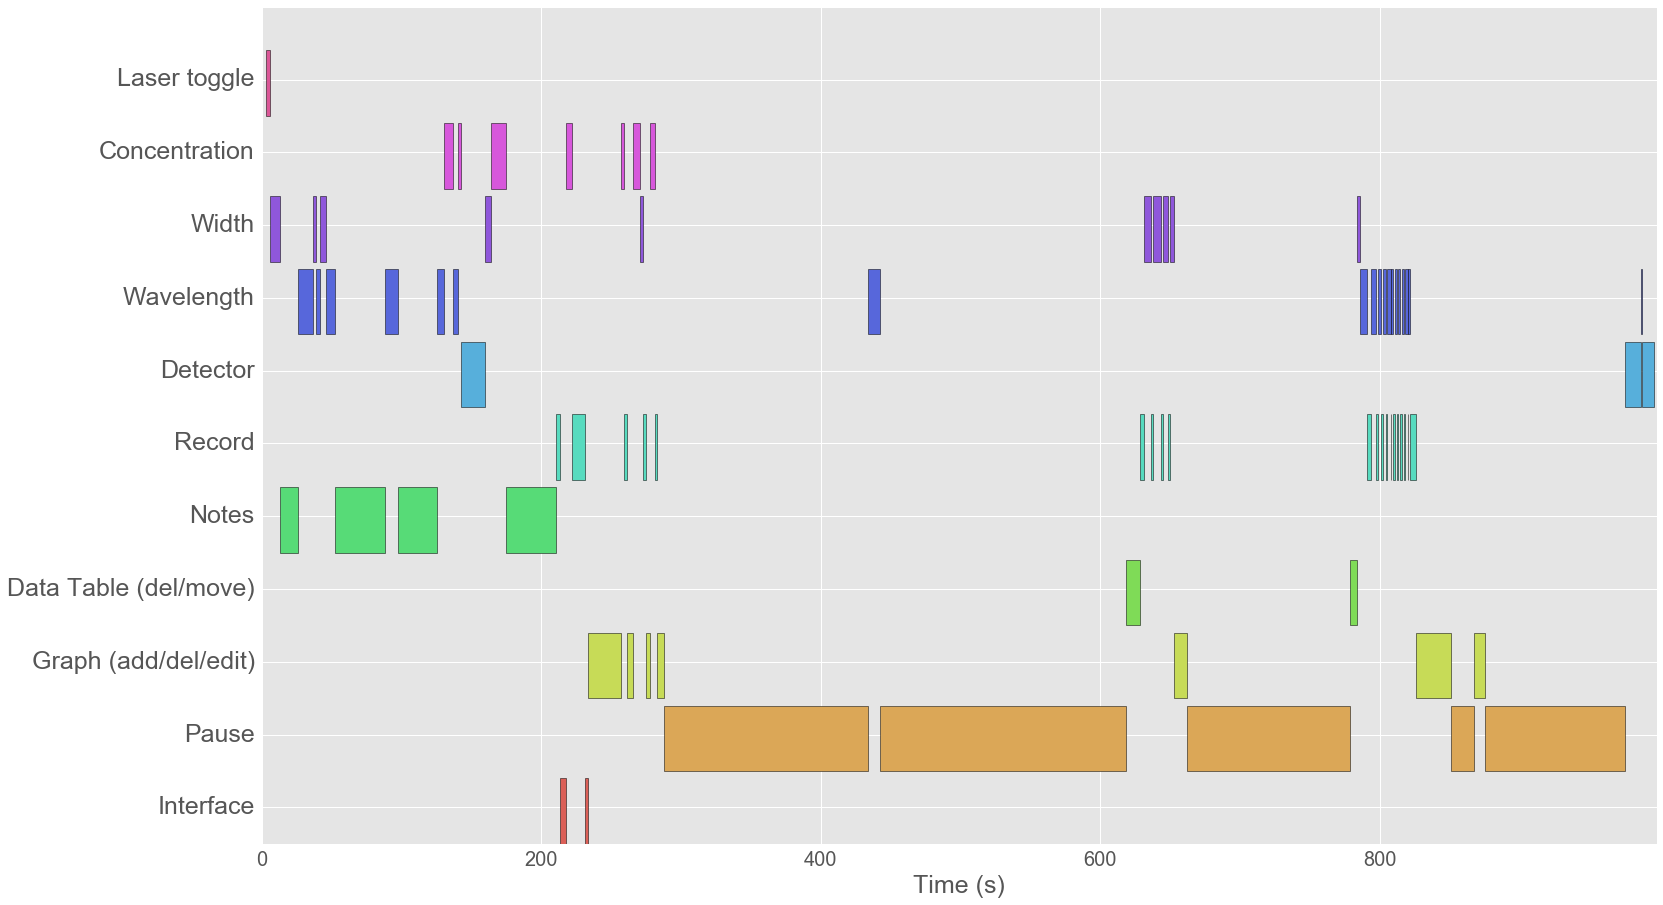

In [16]:
family_plot_order = ['I','P','G','Dt','N','M','Vd','Vw','Vc','Vs','Vl']
plot_barGraph_new(df, '12345678', family_plot_order,ignore=[])

In [17]:
blocks, time_coords = get_blocks_withTime(df, {''})
print blocks

{'': 'VlVcNVwVcVwVcVwNVwNVwVsVwVsVdVcVsNMIVsMIGVsMGVsVcMGVsMGPVwPDtMVcMVcMVcMVcGPDtVcVwMVwMVwMVwMVwMVwMVwMVwMVwMVwMVwMGPGPVdVwVd'}
